In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist, pos_tag
import re
import sys

import json

sns.set_style('darkgrid')

In [2]:
with open ('../data/json_pr.json') as x:
    prj = json.load(x)
    
with open ('../data/json_ra.json') as y:
    raj = json.load(y)

In [3]:
df_prj = pd.DataFrame(prj)
df_raj = pd.DataFrame(raj)

In [4]:
# #confirm latest dfs: 0 nulls.  confirmed
# print(df_prj.isnull().sum())
# print(df_raj.isnull().sum())

# Structure analysis separate from diction:

Number of sentences, sentence length, and punctuation use (. , ?) could be informative.  

2 separate analyses: nlp based on vectorized words (0 structure or punctuation retention), and one based on structure.  

Create new columns for total wordcount, # sentences, average sentence length, total commas / ? / ! (which can be changed into per wordcount or per sentence 'rates' later).  Then drop all of punctuation from selftext for vectorization.  

### Add column with sentence count
Methods based on experimentation in scratch notebook. Which was unnecessary because you literally learned a sentence_tokenizer in class but here we are.

In [5]:
df_prj['num_sentences'] = df_prj['selftext'].map(lambda x: len(re.split(r'[.!?]+', x))-1)
df_raj['num_sentences'] = df_raj['selftext'].map(lambda x: len(re.split(r'[.!?]+', x))-1)

### Add column with average sentence length (by word)

In [6]:
# len counts spaces and characters.  you want wordcount.
length = 'this is twenty lettersS..!?,'
len(length)

28

In [7]:
def avg_words_per_sentence(df):
    
    all_sentences_bypost = []

    for i in df['selftext']:
        all_sentences_bypost.append(re.split(r'[.!?]+', i))
    
    avgwordsper = []

    for post in all_sentences_bypost:
        wordspersentence = []
        for i in post:
            wordspersentence.append(len(i.split()))
        avgwordsper.append(int(np.mean(wordspersentence).round()))
        
    return avgwordsper

In [8]:
df_raj['avg_words_per_sent'] = avg_words_per_sentence(df_raj)
df_prj['avg_words_per_sent'] = avg_words_per_sentence(df_prj)

### Add columns with total wordcount, commas, ?s, and !s

In [9]:
df_raj['wordcount'] = df_raj['selftext'].map(lambda x: len(x.split()))
df_prj['wordcount'] = df_prj['selftext'].map(lambda x: len(x.split()))

In [10]:
df_raj['comma_count'] = df_raj['selftext'].map(lambda x: x.count(','))
df_raj['qmark_count'] = df_raj['selftext'].map(lambda x: x.count('?'))
df_raj['exclamatios'] = df_raj['selftext'].map(lambda x: x.count('!'))

In [11]:
def count_punc(punc, df):
    perpost = []
    for i in df['selftext']:
        perpost.append(i.count(punc))
    return perpost

In [12]:
df_prj['comma_count'] = count_punc(',', df_prj)
df_prj['qmark_count'] = count_punc('?', df_prj)
df_prj['exclamatios'] = count_punc('!', df_prj)

### Add column is_mobile to distinguish if posted by mobile user
Users generally announce if they are posting from mobile phones, but there is no consistent format to this announcement.  Sometimes it's a sentence, sometimes a single word declaration.  ID'ing is_mobile by simply searching for the word 'mobile' will also flag posts containing words like 'automobile', 'immobile', 'mobile bank account', etc ('shitmobile' is one I found in there that I did not expect...).  
Spot check 100 posts from each df to get rate of false positives to see if an is_mobile column is informative.

---

Results from check: 
* relationship_advice had 10.6% false positives (10 of total 94)
* pettyrev had 8% false positive rate (8 of 100 random checks without replacement, total count 395)  

##### Assume a fp rate of 9%, still worth identifying.  Pretty consistent fp rate across both dataframes makes it a reliable enough metric.  Concatenate before adding column. 

In [13]:
#use ctrl-f in jq pretty-print to check if posting from mobile, or talking about mobile homes, etc. 
df_raj.loc[df_raj['selftext'].str.lower().str.contains('mobile')].to_json('../scratch/is_mobile_ra.json', orient='records')

In [14]:
# 10/94 records containing 'mobile' NOT posted from mobile user 
#is_mobile = false positive rate 10.6% for RA
df_raj.loc[df_raj['selftext'].str.lower().str.contains('mobile')].shape

(94, 16)

In [15]:
# repeat for pettyrev.  len = 395.  check first 100.
df_prj.loc[df_prj['selftext'].str.lower().str.contains('mobile')].head(100).to_json('../scratch/is_mobile_pr.json', orient='records')

In [16]:
combo_structured = pd.concat([df_prj, df_raj], axis = 0, ignore_index=True)

In [17]:
combo_structured['is_mobile'] = combo_structured['selftext'].apply(lambda x: 1 if 'mobile' in x.lower() else 0)

In [18]:
combo_structured.is_mobile.value_counts()

0    11519
1      489
Name: is_mobile, dtype: int64

## Special characters to scrub:
* **all URLs:  start with https://...** 
* characters with alphanum attached: I think remove these whole units first (or the attached text), otherwise left with 'n', 'amp', 'u username', etc that won't be picked up by subsequent alphanum filter?
    * ' & amp ;
    * \n
    * u/username
    * (Mobile)
        * edit: leave mobile in place, could be differentiating feature between subreddits
        * edit 2: no matter if scrub or not, already have column indicating is_mobile
* all non-alpha-numerics: \, /, &, * , "", '', -
* emojis 
* I don't think numbers will be informative
* stopwords='english' : word freq table for petty revenge showed top words were all stopwords.  Not informative.

--- 

I ended up CountVectorizing here and joining the above structural columns of interest to single vectorized words and bigrams at the end of this notebook.  Ultimatley, cvec or tfidf was incorporated into my modeling pipelines, so this dataframe was mostly unused.  Regardless, the special-character removal and lemmatization were essential steps for later modeling. 

In [19]:
combo_structured['mod_selftext'] = combo_structured['selftext']

In [20]:
#start with urls so you don't accidentally turn them into text by ditching identifying characters
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: re.sub(r'http\S+', '', x))

In [21]:
# word_tokenizer drops many special characters but keeps 'amp' from &amp;
# drop that unit specifically first:
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: x.replace('&amp;',''))
#also apostrophes: just merge into one word (don't -> dont)
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: x.replace("'",''))

In [22]:
#word_tokenize then return only alpha characters re-joined in original order
#NUMBERS removed
#special characters removed
tokenizer = RegexpTokenizer(r'\w+')

In [23]:
combo_structured['mod_selftext'] = combo_structured['mod_selftext'].apply(lambda x: ' '.join([i for i in tokenizer.tokenize(x.lower()) if i.isascii() and i.isalpha()]))

In [24]:
lemmatizer = WordNetLemmatizer()
combo_structured['lem_selftext'] = combo_structured['mod_selftext'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()]))

In [25]:
# 8 posts that were JUST urls are now blank.  They read as nulls later, so remove now
combo_structured.loc[combo_structured['lem_selftext']=='']

,selftext,subreddit,created_utc,is_self,score,title,author,num_comments,timestamp,year,num_sentences,avg_words_per_sent,wordcount,comma_count,qmark_count,exclamatios,is_mobile,mod_selftext,lem_selftext
2132,https://old.reddit.com/r/funny/comments/d0q3u9...,pettyrevenge,1567827262,True,1,last laugh,arbivark,0,2019-09-06,2019,2,1,1,0,0,0,0,,
2822,https://youtu.be/LoNPNaN8szc,pettyrevenge,1552421399,True,1,pro revenge tries get me arrested? Enjoy your ...,dailycomment1,0,2019-03-12,2019,1,1,1,0,0,0,0,,
2843,https://youtu.be/oRHcvYaIN8s,pettyrevenge,1552523343,True,1,Nuclear revenge Boss wouldn't pay me the money...,dailycomment1,0,2019-03-13,2019,1,1,1,0,0,0,0,,
3091,https://www.reddit.com/r/legaladvice/comments/...,pettyrevenge,1545855280,True,1,This /r/legaladvice OP plans some tasty reveng...,stephen_hoeking,0,2018-12-26,2018,2,1,1,0,0,0,0,,
3405,,pettyrevenge,1537426108,True,1,Hi,BanMeMotherBitches,0,2018-09-19,2018,0,0,0,0,0,0,0,,
5827,https://imgur.com/gallery/PGl2D,pettyrevenge,1468041094,True,30,"Found this on Instagram, thought you guys migh...",Spontaneous_Mullet,13,2016-07-08,2016,1,1,1,0,0,0,0,,
10433,https://www.youtube.com/watch?v=s5hTvWB-4As,relationship_advice,1515567428,True,1,Dream Hill - Night Lights,Raymond_Pope,0,2018-01-09,2018,3,1,1,0,1,0,0,,
11822,http://www.jbklutse.com/9-phrases-important-love/,relationship_advice,1472385694,True,0,9 Phrases more important than ‘I love you’,zardari11,6,2016-08-28,2016,2,1,1,0,0,0,0,,


In [26]:
combo_structured.shape

(12008, 19)

In [27]:
combo_structured= combo_structured[combo_structured['lem_selftext']!='']

In [28]:
combo_structured.reset_index(inplace=True)

In [31]:
combo_structured.head()

,index,selftext,subreddit,created_utc,is_self,score,title,author,num_comments,timestamp,year,num_sentences,avg_words_per_sent,wordcount,comma_count,qmark_count,exclamatios,is_mobile,mod_selftext,lem_selftext
0,0,\n\nI remember during my first year of colleg...,pettyrevenge,1617115680,True,1,How the tables have turned.,BestGuessGuest,79,2021-03-30,2021,12,17,227,6,0,0,0,i remember during my first year of college i h...,i remember during my first year of college i h...
1,1,A bit long TDRL at the end. First post on mobi...,pettyrevenge,1617119446,True,1,I know how to use the radio,Negative_Shake1478,23,2021-03-30,2021,25,15,391,9,0,0,1,a bit long tdrl at the end first post on mobil...,a bit long tdrl at the end first post on mobil...
2,2,Senior year of high school. Last school dance ...,pettyrevenge,1617138131,True,1,Made a girl cry after she stuck gum in my hair,The_Bee_Sneeze,44,2021-03-30,2021,39,10,410,27,2,0,0,senior year of high school last school dance o...,senior year of high school last school dance o...
3,3,"When I was working as a barista, there were tw...",pettyrevenge,1617168650,True,1,Lady waits to use the bathroom every night at ...,snailtearstains,557,2021-03-30,2021,44,12,517,18,3,2,0,when i was working as a barista there were two...,when i wa working a a barista there were two n...
4,4,First let me say: I fucking hate it when peopl...,pettyrevenge,1617204366,True,1,Rude lady talking on phone,Xxtratourettestriall,20,2021-03-31,2021,8,26,233,4,1,2,0,first let me say i fucking hate it when people...,first let me say i fucking hate it when people...


In [32]:
#export csv and json versions
combo_structured.to_csv('../data/allposts_struc.csv', index=False)
combo_structured.to_json('../data/j_allposts_struc.json', orient='records')

### EDA on Word Counts
'mod_selftext' and 'lem_selftext' are pre-processed for Vectorizing: numbers and special characters are removed, everything is lowercase, URLs removed.  
Remove stopwords during vectorization.

---

Compared word frequency plots between non-lemmatized and lemmatized posts.  Lemmatization reduced columns of cvec features by 5,000 and barely changed most frequent words.  Work with lemmatized data for 'parsimony'. Ha.

##### Non-lemmatized posts:

In [33]:
cvec = CountVectorizer(stop_words = 'english')
allposts_cvec = cvec.fit_transform(combo_structured['mod_selftext'])

In [34]:
df_allposts_cvec = pd.DataFrame(allposts_cvec.todense(), columns=cvec.get_feature_names())

In [ ]:
df_allposts_cvec.shape #38_669 columns

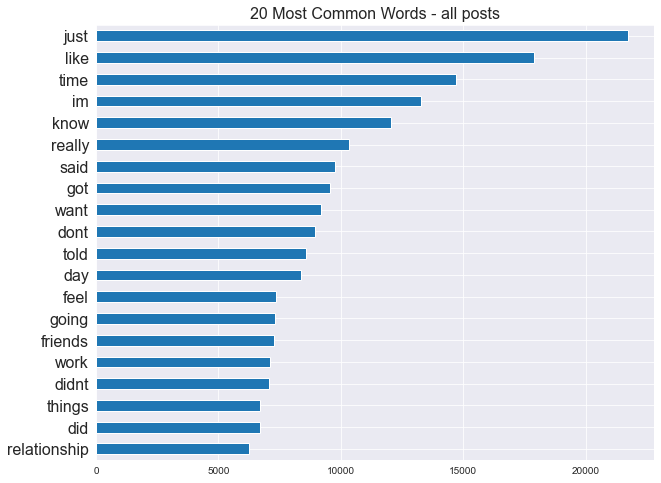

In [35]:
plt.figure(figsize=(10,8))
df_allposts_cvec.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('20 Most Common Words - all posts', size=16);

##### Compare against lemmatized posts
Smaller dataframe with same heavy hitters: use 'lem_selftext' from here on out

In [36]:
lemstop = WordNetLemmatizer()
lemmatized_stopwords = [lemstop.lemmatize(i) for i in stopwords.words('english')]
# lemmatized_stopwords

In [37]:
#lists look v. similar. any differences?
#running with just lemmatized_stopwords somehow increases columns
compare_lemmatized = list(zip(stopwords.words('english'), lemmatized_stopwords))
[i for i in compare_lemmatized if i[0] != i[1]]

[('its', 'it'), ('was', 'wa'), ('has', 'ha'), ('does', 'doe'), ('as', 'a')]

In [38]:
#custom stopwords: 'english', + unique lems + 'im'
my_words = ['wa', 'ha', 'doe', 'a', 'im']
custom_stop = text.ENGLISH_STOP_WORDS.union(my_words)

In [39]:
lem_cvec = CountVectorizer(stop_words=custom_stop)
lem_allposts_cvec = lem_cvec.fit_transform(combo_structured['lem_selftext'])

In [40]:
df_lemcvec = pd.DataFrame(lem_allposts_cvec.todense(), columns=lem_cvec.get_feature_names())

In [41]:
df_lemcvec.shape #33_671 columns = 4998 fewer columns than non-lem --> use this

(12000, 33671)

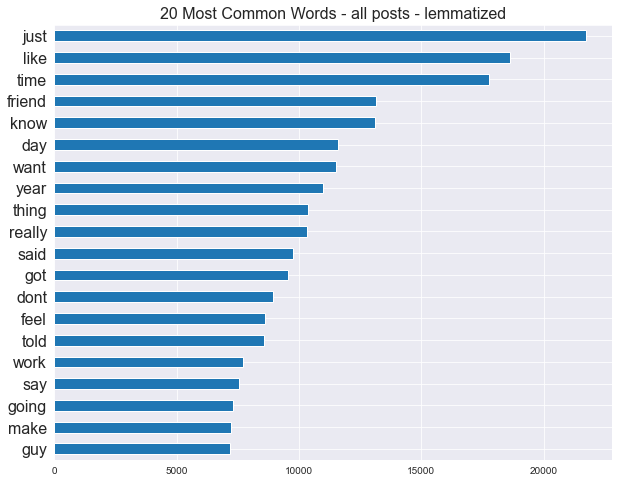

In [42]:
plt.figure(figsize=(10,8))
df_lemcvec.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('20 Most Common Words - all posts - lemmatized', size=16);

## 34,000 columns = too many
Planned to visualize total data and then trim from there, but it is just too large.  Even a simple subset and barh plot did not complete after being run overnight.  So I will add hyperparameters NOW and work with smaller datasets.

---

In lab 5.02, viewing trigrams revealed that I had not handled URLs properly: all trigram results were dominated by meaningless strings from an online magazine/author that had the same base URL for all the articles they posted.  Generate similar visuals here to confirm that my cleaning has been sound.

In [43]:
lem_cvec = CountVectorizer(stop_words=custom_stop, min_df=.01, max_df=.98)
lem_allposts_cvec = lem_cvec.fit_transform(combo_structured['lem_selftext'])

In [44]:
#min=.03 , max=.95 -> 680 col.  Same @ max_df=.98
#min=.01, max=.98 -> 1659 col.  Same @ max=.95
lem_allposts_cvec.shape

(12000, 1666)

In [45]:
df_lemcvec = pd.DataFrame(lem_allposts_cvec.todense(), columns=lem_cvec.get_feature_names())

In [46]:
cols_to_merge = list(combo_structured.drop(columns=['is_self', 'year','selftext', 'mod_selftext','score', 'created_utc', 'lem_selftext', 'title']).columns)
#didn't merge 'year' and 'title' bc those words are present in corpus

In [47]:
vec_merge = pd.concat([df_lemcvec, combo_structured[cols_to_merge]], axis=1)

In [48]:
{'title'}.issubset(df_lemcvec.columns)  #you sneaky sneak
# this messed up 'sums' because vec'd column 'title' and my categorical column 'title'
# drop title-category column from original df before merging vectorized data

True

In [49]:
print(f'shape: {vec_merge.shape}, size: {round(sys.getsizeof(vec_merge)/1000000,1)} MB')

shape: (12000, 1678), size: 163.3 MB


In [50]:
#export for modeling in separate notebook
vec_merge.to_csv('../data/vec_merge_ngram1.csv', index=False)

In [51]:
#subsets for barplots
pettyrev=vec_merge[vec_merge['subreddit']=='pettyrevenge']
relatadv=vec_merge[vec_merge['subreddit']=='relationship_advice']

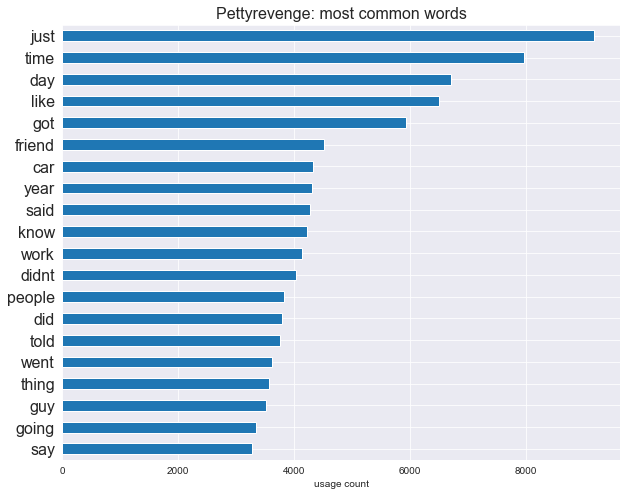

In [52]:
plt.figure(figsize=(10,8))
plt.title('Pettyrevenge: most common words', size=16);
plt.yticks(fontsize=16)
plt.xlabel('usage count')
pettyrev[lem_cvec.get_feature_names()].sum().sort_values(ascending=True).tail(20).plot(kind='barh');

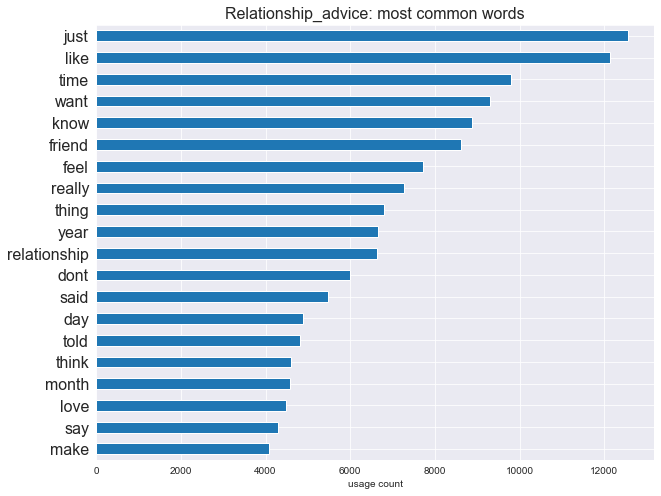

In [53]:
plt.figure(figsize=(10,8))
plt.title('Relationship_advice: most common words', size=16)
plt.yticks(size=16)
plt.xlabel('usage count')
relatadv[lem_cvec.get_feature_names()].sum().sort_values(ascending=True).tail(20).plot(kind='barh');

### Check bigrams
Context may make some of these boring individual words more unique to a particular subreddit ie 'do like' vs 'not like'.  
Include bigrams in vectorized data for modeling - or gridsearch ngram_range=(1,1) vs (1,2) to see if helpful?  
    
    * Dataframe containing subreddit, author, vectorized ngram=1, and bigrams for lemmatized posts exported as csv at the end of this notebook.

In [54]:
cv_bigram = CountVectorizer(ngram_range=(2,2), stop_words=custom_stop, min_df=.01, max_df = .98) 
#no diff in common bigrams if max_df=.98 or None
fit_bigram=cv_bigram.fit_transform(combo_structured['lem_selftext'])
df_bigram = pd.DataFrame(fit_bigram.todense(), columns = cv_bigram.get_feature_names())

In [55]:
bigram_merge = pd.concat([df_bigram, combo_structured[cols_to_merge]], axis=1)

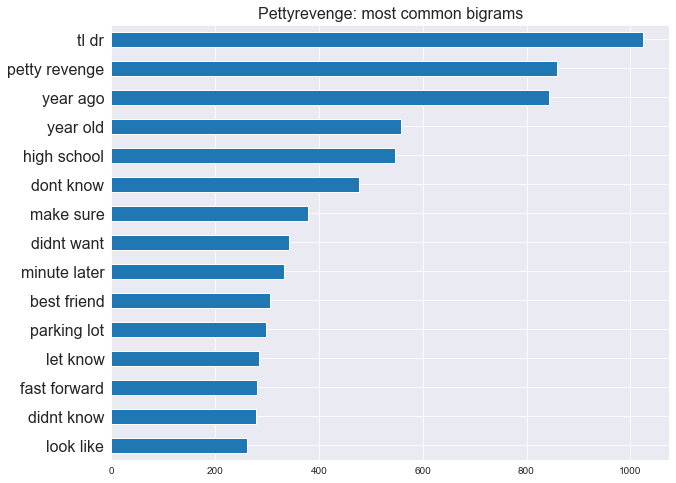

In [56]:
plt.figure(figsize=(10,8))
plt.title('Pettyrevenge: most common bigrams', size=16)
plt.yticks(size=16)
bigram_merge[bigram_merge['subreddit']=='pettyrevenge'][cv_bigram.get_feature_names()].sum().sort_values(ascending=True).tail(15).plot(kind='barh');

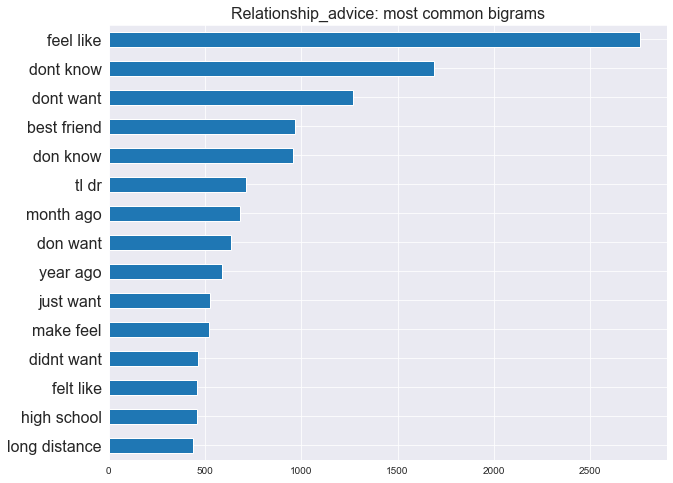

In [57]:
plt.figure(figsize=(10,8))
plt.title('Relationship_advice: most common bigrams', size=16)
plt.yticks(size=16)
bigram_merge[bigram_merge['subreddit']=='relationship_advice'][cv_bigram.get_feature_names()].sum().sort_values(ascending=True).tail(15).plot(kind='barh');

In [58]:
bigram_1gram_merge = pd.concat([df_bigram, vec_merge], axis=1)

In [59]:
bigram_1gram_merge.to_csv('../data/merged_with_bigrams.csv', index=False)

# Continued EDA Visuals specific to presentation
This was originally completed in a separate notebook and I am merging here. To avoid having to change variable names I am re-'importing' data from this same notebook.  Sorry I didn't think this feng shui through fully from the beginning.

In [60]:
data_raw = pd.read_csv('../data/allposts_struc.csv')
data_vecd = pd.read_csv('../data/merged_with_bigrams.csv') #min_df=.01, max_df=.98

In [61]:
#remove extra index column that made it into data_vecd from prior reset_index
data_vecd.drop(columns='index', inplace=True)
data_raw.drop(columns='index', inplace=True)

In [62]:
my_words = ['wa', 'ha', 'doe', 'a', 'im', 'relationship', 'advice','petty','revenge']
new_stop = text.ENGLISH_STOP_WORDS.union(my_words)

## Trigrams

A) With no stopwords filter

In [63]:
cv_trigram = CountVectorizer(ngram_range=(3,3), min_df=.01)
fit_trigram = cv_trigram.fit_transform(data_raw['lem_selftext'])
df_trigram = pd.DataFrame(fit_trigram.todense(), columns = cv_trigram.get_feature_names())

In [64]:
#df_trigram.shape  # max_df=.98, shape=12k,4.  /  max_df=None, shape=12k/745
trigram_merge = pd.concat([df_trigram, data_vecd],axis=1)

<AxesSubplot:title={'center':'Pettyrevenge: most common trigrams'}>

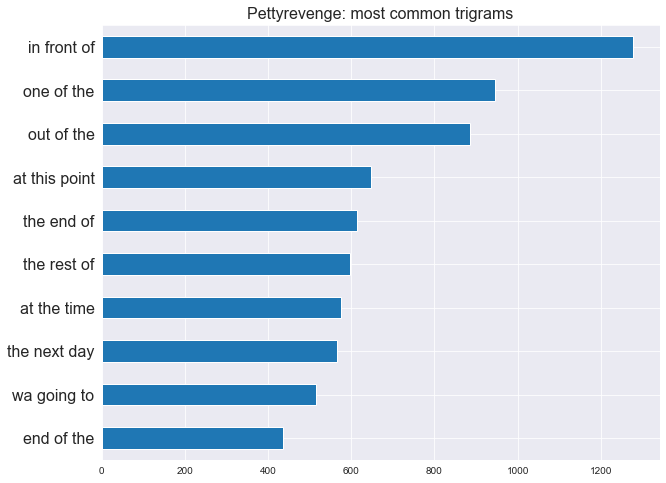

In [65]:
# pettyrev trigrams
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
plt.title('Pettyrevenge: most common trigrams', size=16)
plt.yticks(size=16)
trigram_merge[trigram_merge['subreddit']=='pettyrevenge'][cv_trigram.get_feature_names()].sum().sort_values(ascending=True).tail(10).plot(kind='barh')


<AxesSubplot:title={'center':'Relationship_advice: most common trigrams'}>

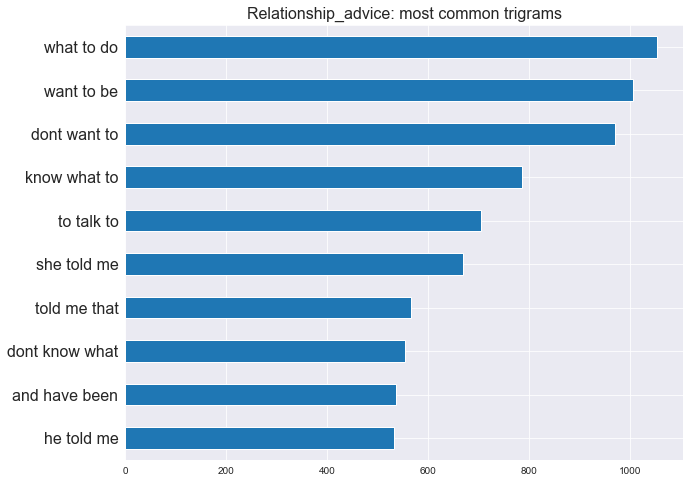

In [66]:
# ra trigrams, top15
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
plt.title('Relationship_advice: most common trigrams', size=16)
plt.yticks(size=16)
trigram_merge[trigram_merge['subreddit']=='relationship_advice'][cv_trigram.get_feature_names()].sum().sort_values(ascending=True).tail(10).plot(kind='barh')


B) With stopwords filter used in modeling

In [71]:
cv_trigram = CountVectorizer(stop_words=new_stop, ngram_range=(3,3), min_df=.01)
fit_trigram = cv_trigram.fit_transform(data_raw['lem_selftext'])
df_trigram = pd.DataFrame(fit_trigram.todense(), columns = cv_trigram.get_feature_names())

In [72]:
trigram_merge = pd.concat([df_trigram, data_vecd],axis=1)

In [73]:
ra_tri_df=pd.DataFrame(trigram_merge[trigram_merge['subreddit']=='relationship_advice'][cv_trigram.get_feature_names()].sum().sort_values(ascending=True))
pr_tri_df=pd.DataFrame(trigram_merge[trigram_merge['subreddit']=='pettyrevenge'][cv_trigram.get_feature_names()].sum().sort_values(ascending=True))


In [74]:
ra_tri_df = ra_tri_df.reset_index().rename(columns={'index':'trigram', 0:'count'}).sort_values('count',ascending=False)
ra_tri_df['subreddit'] = 'relationship_advice'
pr_tri_df = pr_tri_df.reset_index().rename(columns={'index':'trigram', 0:'count'}).sort_values('count', ascending=False)
pr_tri_df['subreddit'] = 'pettyrevenge'
tri_df = pd.concat([ra_tri_df, pr_tri_df], ignore_index=True)

In [75]:
tri_df

,trigram,count,subreddit
0,long story short,159,relationship_advice
1,just dont know,141,relationship_advice
2,just feel like,127,relationship_advice
3,happened year ago,16,relationship_advice
4,happened year ago,183,pettyrevenge
5,long story short,78,pettyrevenge
6,just feel like,5,pettyrevenge
7,just dont know,3,pettyrevenge


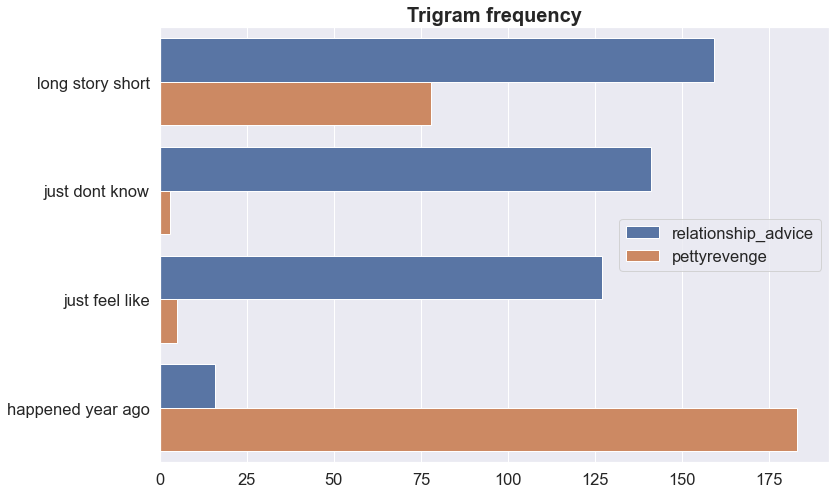

In [76]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12,8))
plt.title("Trigram frequency", size=20, fontweight='bold')
ax = sns.barplot(x='count', 
            y='trigram',
            hue='subreddit',
            data=tri_df,
           orient='h')
ax.set_ylabel("")
ax.set_xlabel("")
plt.legend(loc='best')


## Examine _overlapping_ words in each subreddit's most frequent words
Define relatinoship to each other (rate of classification, ratio)  
ID top 100 words in each subreddit - which are unique?  
    * expanded to top 500; 300 of which overlap  
sum their use - what is rate of use between subs?    
    * ie a 'common' word is XX times more likely to be found in sub Z

In [77]:
singles = CountVectorizer(stop_words=new_stop, min_df=.01)
singles_cvec = singles.fit_transform(data_raw['lem_selftext'])

In [78]:
df_singles= pd.DataFrame(singles_cvec.todense(), columns=singles.get_feature_names())

In [79]:
df_singles = pd.concat([df_singles, data_raw['subreddit']],axis=1)

In [80]:
pettyrev = df_singles[df_singles['subreddit']=='pettyrevenge']
relatadv = df_singles[df_singles['subreddit']=='relationship_advice']

In [81]:
def top_words(df, count, abbrev):
    newdf = pd.DataFrame(df.drop(columns='subreddit').sum().sort_values(ascending=False).head(count))
    newdf = newdf.rename(columns={0:f'{abbrev}_count'})
    return newdf

In [82]:
pr_tops=top_words(pettyrev, 500, 'pr')
ra_tops=top_words(relatadv, 500, 'ra')

In [84]:
#relat_adv has 91% the total words as pettyrev
#scale counts below accordingly (pr*.91) for comparison of word prevalence
data_raw.groupby('subreddit')[['wordcount']].agg(['sum', 'mean'])

wordcount            
                          sum        mean
subreddit                                
pettyrevenge          2290864  387.821906
relationship_advice   2085133  342.217791

In [85]:
join_tops = pd.concat([pr_tops, ra_tops], axis=1).dropna(how='any')
#zip_tops = list(zip(join_tops['pr_count'], join_tops['ra_count']))
join_tops.reset_index(inplace=True)
join_tops.rename(columns={'index':'word'},inplace=True)
join_tops['scaled_pr'] = round(join_tops['pr_count']*.91,1)  #len=328
join_tops['scaled_pr_ra_ratio'] = join_tops['scaled_pr']/join_tops['ra_count']
join_tops['scaled_ra_pr_ratio'] = join_tops['ra_count']/join_tops['scaled_pr']
all_common = join_tops.sort_values('scaled_pr_ra_ratio', ascending=False)
all_common.head(10).append(all_common.tail(10))

,word,pr_count,ra_count,scaled_pr,scaled_pr_ra_ratio,scaled_ra_pr_ratio
6,car,4333.0,621.0,3943.0,6.349436,0.157494
34,minute,2502.0,462.0,2276.8,4.928139,0.202916
85,food,1387.0,301.0,1262.2,4.193355,0.238473
30,room,2641.0,580.0,2403.3,4.143621,0.241335
88,walk,1343.0,295.0,1222.1,4.142712,0.241388
48,class,2150.0,487.0,1956.5,4.017454,0.248914
77,face,1532.0,422.0,1394.1,3.303555,0.302704
119,looked,1106.0,314.0,1006.5,3.205414,0.311972
63,turn,1776.0,528.0,1616.2,3.060985,0.326692
99,dog,1220.0,377.0,1110.2,2.944828,0.339578


In [86]:
#create new categorical label for dominant words, and neutral words 
# within top 500
words_extreme_ra = ['feel', 'love', 'want', 'girlfriend', 'boyfriend', 'ex','talk','recently','help']
words_extreme_pr = ['car', 'food','dad','walk','class','dog','kid','brother','fuck']
words_mild = ['bed', 'change', 'single', 'child', 'literally','wife','daughter','mother']

In [87]:
match_word = words_extreme_ra + words_extreme_pr + words_mild

In [88]:
for_viz=all_common[all_common['word'].isin(match_word)]

In [89]:
hue_list=[]
for i in for_viz['word']:
    if i in (words_extreme_pr):
        hue_list.append('pr')
    if i in (words_extreme_ra):
        hue_list.append('ra')
    if i in (words_mild):
        hue_list.append('equal')

In [90]:
for_viz['hue'] = hue_list

<ipython-input-90-d558e20d2b9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_viz['hue'] = hue_list


In [92]:
for_viz.head()

,word,pr_count,ra_count,scaled_pr,scaled_pr_ra_ratio,scaled_ra_pr_ratio,hue
6,car,4333.0,621.0,3943.0,6.349436,0.157494,pr
85,food,1387.0,301.0,1262.2,4.193355,0.238473,pr
88,walk,1343.0,295.0,1222.1,4.142712,0.241388,pr
48,class,2150.0,487.0,1956.5,4.017454,0.248914,pr
99,dog,1220.0,377.0,1110.2,2.944828,0.339578,pr


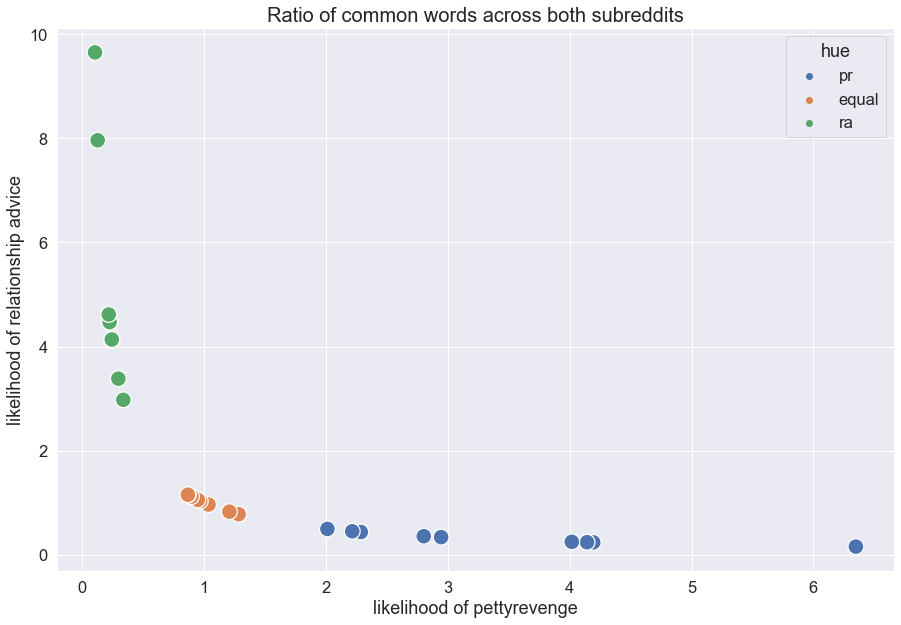

In [95]:
#mehhhhh
plt.figure(figsize=(15,10))
hue_labels=['pettyrevenge indicator', 'equal', 'relationship advice indicator']
sns.scatterplot(x='scaled_pr_ra_ratio', y='scaled_ra_pr_ratio', 
                data=for_viz, hue='hue', marker='o', s=250);
plt.title('Ratio of common words across both subreddits', size=20);
plt.xlabel('likelihood of pettyrevenge')
plt.ylabel('likelihood of relationship advice');

## Word and punctuation quantification

In [96]:
data_raw.groupby('subreddit')[['num_sentences','avg_words_per_sent','comma_count','qmark_count','exclamatios']].mean().round().T

subreddit,pettyrevenge,relationship_advice
num_sentences,23.0,19.0
avg_words_per_sent,19.0,18.0
comma_count,15.0,11.0
qmark_count,1.0,2.0
exclamatios,1.0,0.0


In [97]:
struc_cols = ['num_sentences', 'avg_words_per_sent', 'comma_count', 'qmark_count','exclamatios']
#targets = ['pettyrevenge', 'relationship_advice']
d = data_raw.groupby('subreddit')[struc_cols].mean().round(3).reset_index()

longform = pd.melt(d, id_vars=['subreddit'], var_name='metric', value_name='value')

xlabel_names = {'num_sentences':'# sent.', 'avg_words_per_sent':'sent. len.', 'comma_count':'commas',
               'qmark_count':'?', 'exclamatios':'!'}

longform['xlabs'] = longform['metric'].map(xlabel_names)
longform

,subreddit,metric,value,xlabs
0,pettyrevenge,num_sentences,22.821,# sent.
1,relationship_advice,num_sentences,18.891,# sent.
2,pettyrevenge,avg_words_per_sent,18.919,sent. len.
3,relationship_advice,avg_words_per_sent,18.358,sent. len.
4,pettyrevenge,comma_count,15.173,commas
5,relationship_advice,comma_count,10.646,commas
6,pettyrevenge,qmark_count,0.945,?
7,relationship_advice,qmark_count,1.655,?
8,pettyrevenge,exclamatios,1.146,!
9,relationship_advice,exclamatios,0.321,!


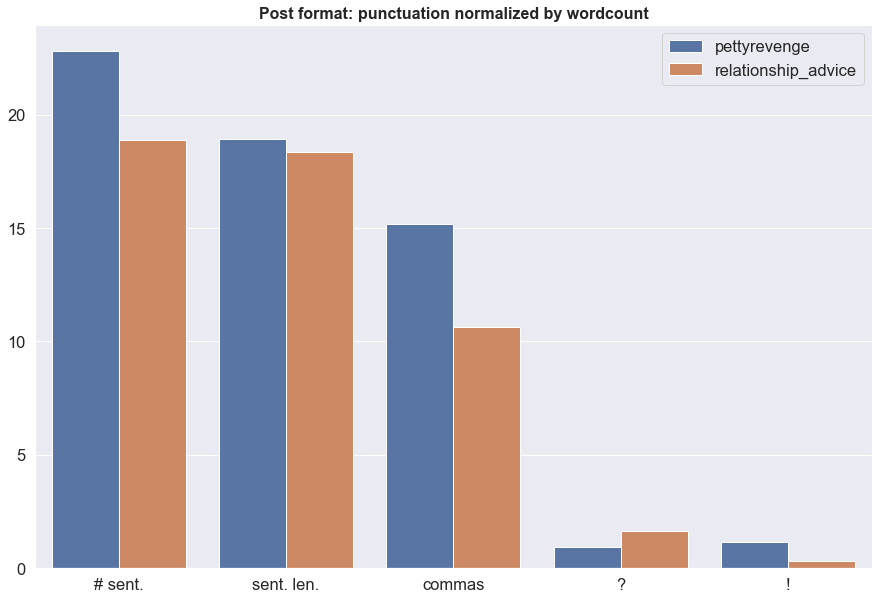

In [99]:
# scale pettyrev to relatadv wordcount (*.91) so punctuation use is a rate ('by wordcount')
normalized=[]
for i in range(0,len(longform)):
    if longform['subreddit'][i] == 'pettyrevenge':
        if longform['metric'][i]=='avg_words_per_sent' or 'num_sentences':
            normalized.append(longform['value'][i])
        else:
            normalized.append(longform['value'][i]*.91)
    else:
        normalized.append(longform['value'][i])

longform['normalized'] = normalized

plt.figure(figsize=(15,10))
sns.barplot(x='xlabs', y='normalized',hue='subreddit', data=longform)
plt.xlabel('')
plt.ylabel('')
plt.title('Post format: punctuation normalized by wordcount', size=16, fontweight='bold')
plt.legend(loc='best');

In [100]:
data_raw.groupby('subreddit')[['wordcount','is_mobile']].agg(['mean', 'std']).round(3)

wordcount          is_mobile       
                         mean      std      mean    std
subreddit                                              
pettyrevenge          387.822  254.697     0.067  0.250
relationship_advice   342.218  316.122     0.015  0.123

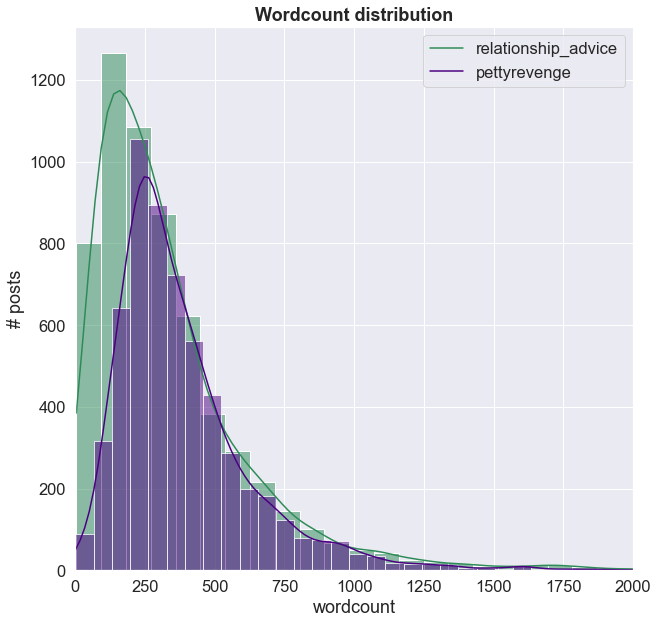

In [101]:
pettyrev=data_raw.loc[data_raw['subreddit']=='pettyrevenge']
relatadv=data_raw.loc[data_raw['subreddit']=='relationship_advice']

plt.figure(figsize=(10,10))
sns.histplot(x=relatadv['wordcount'], color='seagreen', kde=True, bins=50);
sns.histplot(x=pettyrev['wordcount'], color='indigo', kde=True, bins=50);
plt.xlim(0,2000)
plt.legend(labels=['relationship_advice', 'pettyrevenge'])
plt.ylabel('# posts')
plt.title('Wordcount distribution', size=18, fontweight='bold');


## Notes for modeling
(Modeling in separate notebook)
* Use RandomSearch and Bayes Search to save time vs. StupidGridSearch
* hone CountVec params through this process:
    * You just spent a while making a df of countvec ngrams and bigrams, but turns out you'll barely use it because countvec/tfidfvec will be part of your modeling pipelines.  Coolcoolcool.
    * include bigrams _and_ trigrams?
    * adjust stopwords as need
    * min_df=.01, max_df=.98 for the merged ngram=1 and bigram data exported here